<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 4 &ndash; Recurrent Neural Networks</h2>

<b>Authors:</b> B. Schäfl, S. Lehner, J. Brandstetter, E. Kobler, A. Schörgenhumer<br>
<b>Date:</b> 03-05-2022

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h2>Table of contents</h2>
<ol>
    <a href="#latch-sequence-set"><li style="font-size:large;font-weight:bold">The Latch Sequence Data Set</li></a>
    <ol style="margin-bottom:15px">
        <a href="#latch-sequence-set-split-prepare"><li style="font-size:medium">Splitting and preparing</li></a>
        <a href="#latch-sequence-set-visualize"><li style="font-size:medium">Visualizing data set statistics</li></a>
        <a href="#tasks-one"><li style="font-size:medium">Tasks</li></a>
    </ol>
    <a href="#latch-naive-approach"><li style="font-size:large;font-weight:bold">The Naïve Approach</li></a>
    <ol style="margin-bottom:15px">
        <a href="#latch-naive-approach-sort"><li style="font-size:medium">Sorting data set</li></a>
        <a href="#tasks-two"><li style="font-size:medium">Tasks</li></a>
    </ol>
    <a href="#latch-recurrent-approach"><li style="font-size:large;font-weight:bold">The Recurrent Approach</li></a>
    <ol style="margin-bottom:15px">
        <a href="#latch-recurrent-approach-elman"><li style="font-size:medium">Elman RNNs</li></a>
        <a href="#latch-recurrent-approach-lstm"><li style="font-size:medium">Long Short-Term Memory (LSTM)</li></a>
        <a href="#latch-recurrent-approach-both"><li style="font-size:medium">Elman RNN vs. LSTM</li></a>
        <a href="#tasks-three"><li style="font-size:medium">Tasks</li></a>
    </ol>
        <a href="#latch-gradients"><li style="font-size:large;font-weight:bold">Analyzing Gradients of RNNs</li></a>
    <ol style="margin-bottom:15px">
        <a href="#latch-gradients-elman"><li style="font-size:medium">Elman RNN</li></a>
        <a href="#latch-gradients-lstm"><li style="font-size:medium">Long Short-Term Memory (LSTM)</li></a>
        <a href="#latch-gradients-elman-vs-lstm"><li style="font-size:medium">Elman RNN vs LSTM</li></a>
        <a href="#tasks-four"><li style="font-size:medium">Tasks</li></a>
    </ol>
</ol>

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>
This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which might require small code modifications. Most/All of the used functions are imported from the file <code>u4_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u4_utils.py</code> need to be installed.

In [1]:
# Import pre-defined utilities specific to this notebook.
import u4_utils as u4

# Import additional utilities needed in this notebook.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u4.setup_jupyter()

<h3 style="color:rgb(0,120,170)">Module versions</h3>
As mentioned in the introductiory slides, specific minimum versions of Python itself as well as of used modules is recommended.

In [2]:
u4.check_module_versions()

Installed Python version: 3.9 (✓)
Installed numpy version: 1.21.5 (✓)
Installed pandas version: 1.4.1 (✓)
Installed PyTorch version: 1.10.2+cpu (✓)
Installed matplotlib version: 3.5.1 (✓)
Installed seaborn version: 0.11.2 (✓)


<a name="latch-sequence-set"></a><h2>The Latch Sequence Data Set</h2>
<p>We study an easy example of learning long-term dependencies by using a modified <i>latch task</i>. The original latch task was introduced by Hochreiter and Mozer:
<center>
    <cite>Sepp Hochreiter, Michael Mozer, 2001. A discrete probabilistic memory model for discovering dependencies in time. Artificial Neural Networks -- ICANN 2001, 13, pp.661-668.</cite>
</center></p>

<p>The essence of this task is that a sequence of inputs is presented, beginning with one of two symbols, <b>A</b> or <b>B</b>, and after a variable number of time steps, the model has to output a corresponding symbol. Thus, the task requires memorizing the original input over time. It has to be noted that in the <i>original</i> task desription, both class-defining symbols must only appear at the first position of an instance.</p>

<p>The <i>modified</i> version of this task used in this notebook relaxes the requirements of <b>A</b> and <b>B</b> a little bit, as both symbols are allowed to occur <i>anywhere</i> in the sequence. Additionally, a third <i>reserved</i> symbol <b>C</b> is introduced, with a <i>pair</i> of them serving as the <i>prefix</i> w.r.t. to the class-defining symbol. <b>C</b> may only occur in this constellation, but the triple may occor at <i>any</i> position in a sequence. Defining arguments are:

<table>
    <tr>
        <th>Argument</th>
        <th>Value (used in this demo)</th>
        <th>Description</th>
    </tr>
    <tr>
        <th><code>num_samples</code></th>
        <th>2048</th>
        <th>Amount of samples of the full dataset.</th>
    </tr>
    <tr>
        <th><code>num_instances</code></th>
        <th>48</th>
        <th>Amount of instances per sample (sample length).</th>
    </tr>
    <tr>
        <th><code>num_characters</code></th>
        <th>26</th>
        <th>Amount of different characters (size of the one-hot encoded vector).</th>
    </tr>
    <tr>
        <th><code>num_targets</code></th>
        <th>2</th>
        <th>Amount of different characters used as possible targets.</th>
    </tr>
</table>

Let's define the dataset using previously mentioned properties as well as a logging directory for storing all auxiliary outputs like performance plots.</p>

In [3]:
data_latch = u4.LatchSequenceSet(
    num_samples=2048,
    num_instances=48,
    num_characters=26,
    num_targets=2,
    seed=42)

# Visualize the last generated sequence of the latch data set.
data_sample = pd.DataFrame(data_latch[-1][0].transpose(0, 1).numpy()).astype(int)
data_sample.style.applymap(lambda _: f'color: {"red" if _ == 1.0 else "default"};font-weight: bold')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


<p>In the tabular visualization above, it can be clearly seen that a <b>C</b> only appears <i>once</i> as a consecutive pair. Exactly what we assumed according to the data set description above. Generally speaking, each <i>column</i> in the table corresponds to a one-hot encoded vector and denotes a <i>timestep</i>, whereas each <i>row</i> corresponds to the <i>type</i> of character – e.g. row $2$ symbolizes a <b>C</b>.</p>

<a name="latch-sequence-set-split-prepare"></a><h3 style="color:rgb(0,120,170)">Split and Prepare Data Set</h3>
<p><p>Before we can start with analyzing the sequence data set discussed above, we have to split our data set into a <i>training set</i> and into a <i>test set</i>. The procedure should already be familiar to you from the previous exercises. We now divide the data set between the training set and the test set in a ratio of $5:1$. Note that the train-test split is <i>not</i> performed randomly in this scenario, as the data set was already generated randomly.</p></p>

In [4]:
# Specify batch as well as test size.
batch_size = 32
test_size = min(max(1, data_latch.num_samples // 6), len(data_latch) - 1)

# Create data loader of training set.
sampler_train = torch.utils.data.SubsetRandomSampler(list(range(
    test_size, data_latch.num_samples)))
data_loader_train = torch.utils.data.DataLoader(
    dataset=data_latch, batch_size=batch_size, sampler=sampler_train)

# Create data loader of test set.
sampler_test = torch.utils.data.SubsetRandomSampler(list(range(test_size)))
data_loader_test = torch.utils.data.DataLoader(
    dataset=data_latch, batch_size=batch_size, sampler=sampler_test)

In [5]:
print(f'The training set consists of "{len(sampler_train)}" samples, '
      f'whereas the test set comprises "{len(sampler_test)}" samples.')

The training set consists of "1707" samples, whereas the test set comprises "341" samples.


<a name="latch-sequence-set-visualize"></a><h3 style="color:rgb(0,120,170)">Visualizing data set statistics</h3>

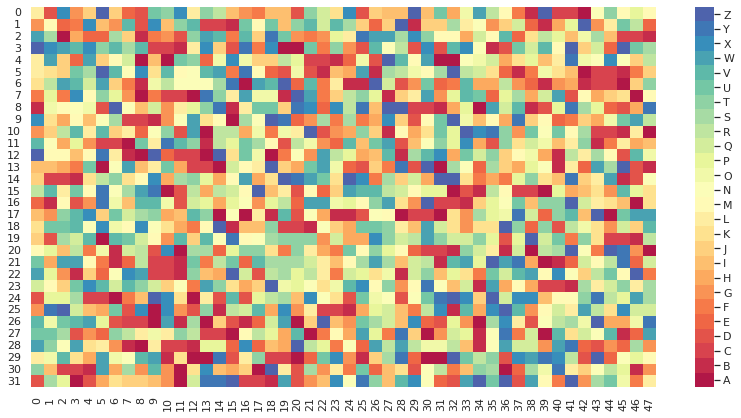

In [6]:
# Set random seed for reproducibility.
u4.set_seed(42)

# Prepare mini-batch of latch sequence data set for plotting.
data_heatmap = iter(data_loader_train).next()[0]
data_heatmap = pd.DataFrame(map(lambda _: torch.argmax(_, dim=1).numpy(), data_heatmap))

# Plot heatmap of a mini-batch of the latch sequence data set w.r.t. the comprised characters.
u4.plot_heatmap(data=data_heatmap, figsize=(14, 7))

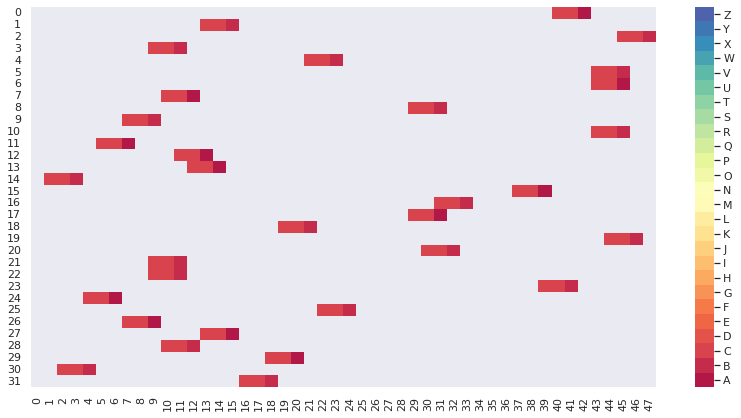

In [7]:
# Set random seed for reproducibility.
u4.set_seed(42)

# Prepare mini-batch of latch sequence data set for plotting.
data_heatmap = iter(data_loader_train).next()[0]
data_heatmap = pd.DataFrame(map(lambda _: torch.argmax(_, dim=1).numpy(), data_heatmap))

# Plot heatmap of a mini-batch of the latch sequence data set w.r.t. the comprised characters.
u4.plot_heatmap(data=data_heatmap, prefix_mask=True, prefix_index=data_latch.num_targets, figsize=(14, 7))

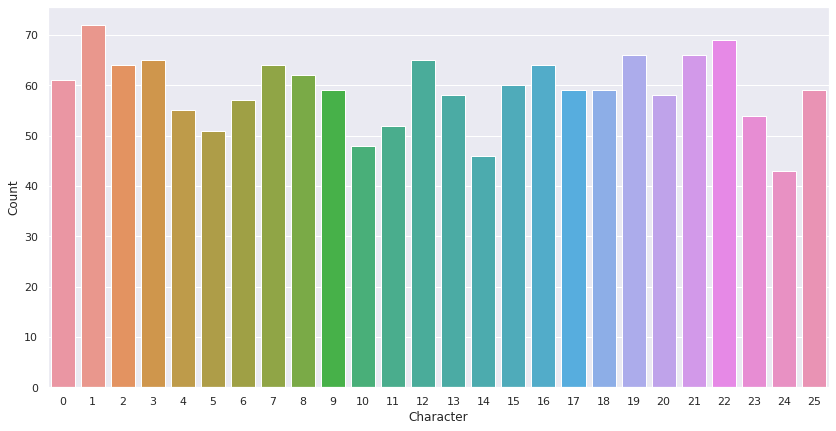

In [8]:
# Set random seed for reproducibility.
u4.set_seed(42)

# Prepare mini-batch of latch sequence data set for plotting.
data_histogram = iter(data_loader_train).next()[0]
data_histogram = pd.DataFrame(map(lambda _: torch.argmax(_, dim=1).numpy(), data_histogram))
data_histogram = data_histogram.to_numpy().flatten()

# Plot heatmap of a mini-batch of the latch sequence data set w.r.t. the comprised characters.
fig, ax = plt.subplots(figsize=(14, 7))
count_plot = sns.countplot(x=data_histogram, ax=ax)
_ = count_plot.set(xlabel='Character', ylabel='Count')

<a name="tasks-one"></a><h3 style="color:rgb(0,120,170)">Tasks</h3>
    <div class="alert alert-warning">
        Execute the notebook until here and try to solve the following tasks:
        <ul>
            <li>Generate latch sequence data sets with different values for the various defining properties as described in the table above.</li>
            <li>For each newly generated latch sequence data set, repeat all visualizations.</li>
            <li>Especially w.r.t. small values of <tt>num_characters</tt>, do you observe something peculiar?</li>
        </ul>
</div>

<a name="latch-naive-approach"></a><h2>The Naïve Approach</h2>
<p>When tackling a new problem, already known and proven tools are often applied first. For this very reason, we are implementing a <i>dense feed-forward</i> network for handling the latch sequence task as discussed previously. As the type of data at hand is a <i>sequence</i> one, we need to <i>flatten</i> the input in order to be able to process it with this kind of architecture.</p>
<table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1</td>
            <td>fully connected</td>
            <td>$10$ output features</td>
        </tr>
        <tr>
            <td>2</td>
            <td>ReLU</td>
            <td>-</td>
        </tr>
        <tr>
            <td>3</td>
            <td>fully connected</td>
            <td>$2$ output features</td>
        </tr>
        <tr>
            <td>4</td>
            <td>output</td>
            <td>-</td>
        </tr>
    </table>

In [9]:
class DenseFNN(torch.nn.Module):
    """
    Dense feed-forward network tailored to process latch sequence data.
    """
    
    def __init__(self, input_size: int, hidden_size: int = 10, output_size: int = 2):
        super(DenseFNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(self.fc1.out_features, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [10]:
# Set random seed for reproducibility.
u4.set_seed(42)

# Create DenseFNN instance and the corresponding optimizer to use.
target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fnn_model = DenseFNN(input_size=data_latch.num_instances * data_latch.num_characters, output_size=data_latch.num_targets).to(target_device)
optimizer = torch.optim.Adam(fnn_model.parameters(), lr=1e-3)

# Print the architecture of the DenseFNN instance.
print(fnn_model, end='\n\n')

# Train and evaluate DenseFNN instance on the latch sequence training set.
num_epochs = 10
for epoch in range(num_epochs):
    
    # Train DenseFNN instance for one epoch.
    u4.train_network(
        model=fnn_model, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    # Evaluate current DenseFNN instance.
    performance = u4.test_network(
        model=fnn_model, data_loader=data_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

# Evaluate final model on test data set.
performance = u4.test_network(
    model=fnn_model, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

DenseFNN(
  (fc1): Linear(in_features=1248, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

Epoch: 01 / Loss: 0.0208 / Accuracy: 0.7217
Epoch: 02 / Loss: 0.0184 / Accuracy: 0.8436
Epoch: 03 / Loss: 0.0152 / Accuracy: 0.8653
Epoch: 04 / Loss: 0.0125 / Accuracy: 0.8846
Epoch: 05 / Loss: 0.0105 / Accuracy: 0.9069
Epoch: 06 / Loss: 0.0089 / Accuracy: 0.9256
Epoch: 07 / Loss: 0.0079 / Accuracy: 0.9397
Epoch: 08 / Loss: 0.0067 / Accuracy: 0.9543
Epoch: 09 / Loss: 0.0057 / Accuracy: 0.9701
Epoch: 10 / Loss: 0.0050 / Accuracy: 0.9813

Final loss: 0.0307 / Final accuracy: 0.5718


<p>The performance of the <i>dense feed-forward</i> network is not really astonishing, to say the least. Especially if one compares the performance with a simple <i>dice roll</i>, which leads to approximately the same accuracy on the <i>test</i> set:</p>

In [11]:
class TheMightyDice(torch.nn.Module):
    """
    Dice roll "network" tailored to deliver random outcomes.
    """
    
    def __init__(self, output_size: int = 2):
        super(TheMightyDice, self).__init__()
        self.__output_size = output_size
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.rand(size=(x.shape[0], self.__output_size), device=x.device)

In [1]:
# Set random seed for reproducibility.
u4.set_seed(42)

# Evaluate dice model on test data set.
performance = u4.test_network(
    model=TheMightyDice(output_size=data_latch.num_targets).to(device=target_device), data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

NameError: name 'u4' is not defined

<p>As already assumed, the performance is not really <i>that</i> bad when simply randomly choosing the outcome. This does <i>not</i> put the previously trained dense feed-forward network in a good position.</p>

<a name="latch-naive-approach-sort"></a><h3 style="color:rgb(0,120,170)">Sorting data set</h3>
<p>As we know the innards of the latch sequence data set, we can <i>cheat</i> a little bit by resorting the class-defining sub-sequences to the beginning of each sequence. Of course, this only serves for analysis purposes, as we already have to know the <i>groundtruth</i> of normally unseen data – which would defeat the purpose of any predictive model.</p>

In [13]:
# Set random seed for reproducibility.
u4.set_seed(42)

# Resort the latch sequence data set.
data_latch_sorted = data_latch.resort()

# Specify batch as well as test size.
batch_size = 32
test_size = min(max(1, data_latch_sorted.num_samples // 6), len(data_latch_sorted) - 1)

# Create data loader of training set.
sampler_train_sorted = torch.utils.data.SubsetRandomSampler(list(range(
    test_size, data_latch_sorted.num_samples)))
data_loader_train_sorted = torch.utils.data.DataLoader(
    dataset=data_latch_sorted, batch_size=batch_size, sampler=sampler_train_sorted)

# Create data loader of test set.
sampler_test_sorted = torch.utils.data.SubsetRandomSampler(list(range(test_size)))
data_loader_test_sorted = torch.utils.data.DataLoader(
    dataset=data_latch_sorted, batch_size=batch_size, sampler=sampler_test_sorted)

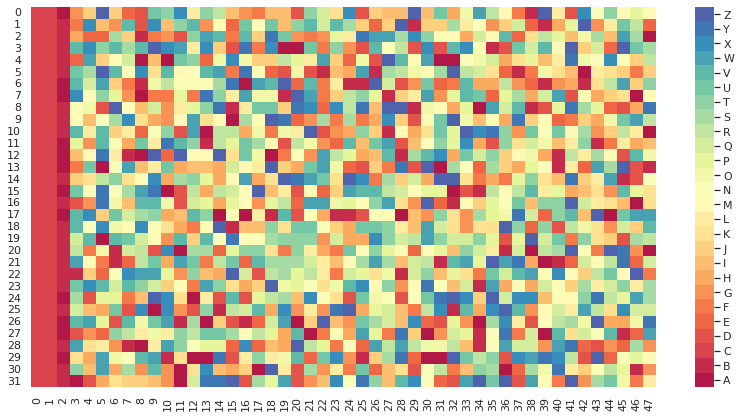

In [14]:
# Set random seed for reproducibility.
u4.set_seed(42)

# Prepare mini-batch of latch sequence data set for plotting.
data_heatmap = iter(data_loader_train_sorted).next()[0]
data_heatmap = pd.DataFrame(map(lambda _: torch.argmax(_, dim=1).numpy(), data_heatmap))

# Plot heatmap of a mini-batch of the latch sequence data set w.r.t. the comprised characters.
u4.plot_heatmap(data=data_heatmap, prefix_mask=False, figsize=(14, 7))

<p>This heatmap perfectly shows the result of the resorting: the class-defining sub-sequences are now at the <i>beginning</i> of each sequence. We even do not need to mask them in order to be able to recognize them. Let's retrain a dense feed-forward model, maybe it performs better if the position of the class-defining <i>timestep</i> is fixed.</p>

In [15]:
# Set random seed for reproducibility.
u4.set_seed(42)

# Create DenseFNN instance and the corresponding optimizer to use.
target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fnn_model = DenseFNN(input_size=data_latch_sorted.num_instances * data_latch_sorted.num_characters, output_size=data_latch_sorted.num_targets).to(target_device)
optimizer = torch.optim.Adam(fnn_model.parameters(), lr=1e-3)

# Train and evaluate DenseFNN instance on the latch sequence training set.
num_epochs = 10
for epoch in range(num_epochs):
    
    # Train DenseFNN instance for one epoch.
    u4.train_network(
        model=fnn_model, data_loader=data_loader_train_sorted, device=target_device, optimizer=optimizer)
    
    # Evaluate current DenseFNN instance.
    performance = u4.test_network(
        model=fnn_model, data_loader=data_loader_train_sorted, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

# Evaluate final model on test data set.
performance = u4.test_network(
    model=fnn_model, data_loader=data_loader_test_sorted, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

Epoch: 01 / Loss: 0.0194 / Accuracy: 0.8207
Epoch: 02 / Loss: 0.0146 / Accuracy: 0.9777
Epoch: 03 / Loss: 0.0085 / Accuracy: 0.9918
Epoch: 04 / Loss: 0.0047 / Accuracy: 1.0000
Epoch: 05 / Loss: 0.0027 / Accuracy: 1.0000
Epoch: 06 / Loss: 0.0017 / Accuracy: 1.0000
Epoch: 07 / Loss: 0.0012 / Accuracy: 1.0000
Epoch: 08 / Loss: 0.0009 / Accuracy: 1.0000
Epoch: 09 / Loss: 0.0007 / Accuracy: 1.0000
Epoch: 10 / Loss: 0.0005 / Accuracy: 1.0000

Final loss: 0.0025 / Final accuracy: 0.9941


<p>Great, the model achieves almost a perfect accuracy on the test set! But of course this task is now trivial since the model just has to output whatever it finds at the <i>third</i> input position (after the <i>two</i> reserved symbols, a.k.a. the <i>prefix</i>). For this task the value of all other timesteps in the sequence is <i>irrelevant</i>. And still, the model does <i>not</i> deliver a <i>perfect</i> result.</p>

<p>This changes if we place the class-defining label at a <i>random</i> position in the sequence. Now the two reserved symbols (prefix) are <i>crucial</i>, as they indicate that the next timestep holds the target value. We've already seen that this randomization completely dumps the performance of a dense feed-forward model.</p>

<p>The reason for this behavior is that in the latch sequence data set, the relative positions of the single timesteps to each other <i>matter</i>! This can clearly be seen, as we need to find the <i>prefix</i> and return the timestep afterwards as the prediction – hence our models need to be able to find a specific <i>ordering</i> of a sub-sequence. In a dense feed-forward network, however, if the position of this sub-sequence changes with a new input (i.e. the input features are <i>shuffled</i>), the model is <i>not</i> able to react accordingly, as no positional information is preserved.</p>

<a name="tasks-two"></a><h3 style="color:rgb(0,120,170)">Tasks</h3>
    <div class="alert alert-warning">
        Execute the notebook until here and try to solve the following tasks:
        <ul>
            <li>Generate latch sequence data sets with different values for the various defining properties as described in the table above.</li>
            <li>For each newly generated latch sequence data set, train a <tt>DenseFNN</tt> model. Do the performances vary?</li>
            <li>Try to interpret the (eventually) varying performances. Take a look at the corresponding data set visualizations.</li>
        </ul>
</div>

<a name="latch-recurrent-approach"></a><h2>The Recurrent Approach</h2>
<p>Consequently, we need a model that processes sequence elements in dependence of the previous sequence elements. <i>Recurrent Neural Networks (RNN)</i> achieve exactly this by consecutively processing each sequence element individually together with the output produced from the previous sequence element. The following image illustrates such an RNN:

<ul>
    <li>$x_t$ corresponds to the input at timestep $t$ (i.e. the sequence element at position $t$)</li>
    <li>$h_t$ corresponds to the output at timestep $t$ which is fed back as an additional input at the next timestep (i.e. as a <i>context</i>)</li>
</ul>

Here, the process of consecutively passing sequence elements to the RNN is unrolled in time, i.e. time progresses from the left to the right. You can see how each sequence element is processed together with the output of the previous timestep (if there is a previous element).</p>
<p>
    <center>
        <img src="./resources/rnn_unrolled_up.png" alt="Image not found!" style="background-color:white"/>
    </center>
</p>

<p>Now let's train <i>two</i> different recurrent network types on the latch sequence data set with randomly positioned class-defining sub-sequences. We do not need to resort the sequences as we did previously, as recurrent networks are able to process dependencies between different timesteps – with various success, as we'll see in the next sections.
<ul>
    <li>Elman RNN</li>
    <li>Long Short-Term Memory (LSTM)</li>
</ul></p>

<a name="latch-recurrent-approach-elman"></a><h3 style="color:rgb(0,120,170)">Elman RNNs</h3>
<p>The Elman RNN is one of the first definitions of a recurrent neural network and naturally quite simple:
<center>
    \begin{equation}
        h_{t} = \tanh{\left(W_{ih}x_{t} + W_{hh}h_{t-1} + b_{hh}\right)}
    \end{equation}
</center></p>
    
<p>We are using the implementation provided by PyTorch, more information may be found in the <a href="https://pytorch.org/docs/stable/generated/torch.nn.RNN.html?highlight=rnn#torch.nn.RNN">official documentation</a>.</p>

In [16]:
class ElmanRNN(torch.nn.Module):
    """
    Elman RNN tailored to process latch sequence data.
    """
    
    def __init__(self, input_size: int, hidden_size: int = 10, output_size: int = 2):
        super(ElmanRNN, self).__init__()
        self.rnn1 = torch.nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = torch.nn.Linear(self.rnn1.hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.rnn1(x)[0][:, -1, :]
        return self.fc1(x)

In [17]:
# Set random seed for reproducibility.
u4.set_seed(42)

# Create ElmanRNN instance and the corresponding optimizer to use.
target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model = ElmanRNN(input_size=data_latch.num_characters, output_size=data_latch.num_targets).to(target_device)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)

# Print the architecture of the ElmanRNN instance.
print(rnn_model, end='\n\n')

# Train and evaluate ElmanRNN instance on the latch sequence training set.
num_epochs = 10
for epoch in range(num_epochs):
    
    # Train ElmanRNN instance for one epoch.
    u4.train_network(
        model=rnn_model, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    # Evaluate current ElmanRNN instance.
    performance = u4.test_network(
        model=rnn_model, data_loader=data_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

# Evaluate final model on test data set.
performance = u4.test_network(
    model=rnn_model, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

ElmanRNN(
  (rnn1): RNN(26, 10, batch_first=True)
  (fc1): Linear(in_features=10, out_features=2, bias=True)
)

Epoch: 01 / Loss: 0.0219 / Accuracy: 0.5272
Epoch: 02 / Loss: 0.0218 / Accuracy: 0.5354
Epoch: 03 / Loss: 0.0217 / Accuracy: 0.5325
Epoch: 04 / Loss: 0.0214 / Accuracy: 0.5665
Epoch: 05 / Loss: 0.0199 / Accuracy: 0.6924
Epoch: 06 / Loss: 0.0186 / Accuracy: 0.7381
Epoch: 07 / Loss: 0.0180 / Accuracy: 0.7557
Epoch: 08 / Loss: 0.0186 / Accuracy: 0.7340
Epoch: 09 / Loss: 0.0167 / Accuracy: 0.7856
Epoch: 10 / Loss: 0.0166 / Accuracy: 0.7768

Final loss: 0.0177 / Final accuracy: 0.7566


<p>The performance of the <i>Elman RNN</i> is by far better than the one from the <i>dense feed-forward</i> network, exactly as assumed. Let's try our <i>cheat</i> w.r.t. the sorting of the sequences again, maybe this will further improve the performance of the <i>Elman RNN</i>, like it did when applying a dense feed-forward network?</p>

In [18]:
# Set random seed for reproducibility.
u4.set_seed(42)

# Create ElmanRNN instance and the corresponding optimizer to use.
target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model = ElmanRNN(input_size=data_latch_sorted.num_characters, output_size=data_latch_sorted.num_targets).to(target_device)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-2)

# Train and evaluate ElmanRNN instance on the latch sequence training set.
num_epochs = 10
for epoch in range(num_epochs):
    
    # Train ElmanRNN instance for one epoch.
    u4.train_network(
        model=rnn_model, data_loader=data_loader_train_sorted, device=target_device, optimizer=optimizer)
    
    # Evaluate current ElmanRNN instance.
    performance = u4.test_network(
        model=rnn_model, data_loader=data_loader_train_sorted, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

# Evaluate final model on test data set.
performance = u4.test_network(
    model=rnn_model, data_loader=data_loader_test_sorted, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

Epoch: 01 / Loss: 0.0219 / Accuracy: 0.5185
Epoch: 02 / Loss: 0.0218 / Accuracy: 0.5278
Epoch: 03 / Loss: 0.0217 / Accuracy: 0.5536
Epoch: 04 / Loss: 0.0216 / Accuracy: 0.5489
Epoch: 05 / Loss: 0.0215 / Accuracy: 0.5741
Epoch: 06 / Loss: 0.0213 / Accuracy: 0.5741
Epoch: 07 / Loss: 0.0213 / Accuracy: 0.5817
Epoch: 08 / Loss: 0.0213 / Accuracy: 0.5759
Epoch: 09 / Loss: 0.0211 / Accuracy: 0.6093
Epoch: 10 / Loss: 0.0214 / Accuracy: 0.5952

Final loss: 0.0226 / Final accuracy: 0.5015


<p>It seems that this change completely destroyed the performance of the <i>Elman RNN</i>. Compared with the <i>random dice roll</i> as discussed previously, we see that the performance is nearly random – so the <i>Elman RNN</i> seems to simply <i>guess</i> the outcomes. Why is this the case? The sorting helped the dense feed-feedfoward network, so why didn't it help this time? Actually, the explanation for this behavior was already discussed a few exercises ago, but before digging into it, let's implement and apply a more advanced recurrent neural network architecture.</p>

<a name="latch-recurrent-approach-lstm"></a><h3 style="color:rgb(0,120,170)">Long Short-Term Memory (LSTM)</h3>
<p>The <i>Long Short-Term Memory (LSTM)</i> is a quite prominent and often used architecture in the recurrent case. It was designed and published by <a href="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320&rep=rep1&type=pdf">Hochreiter and Schmidhuber</a>:
    <center>
        <cite>
            Hochreiter, S. and Schmidhuber, J., 1997. Long short-term memory. Neural computation, 9(8), pp.1735-1780.
        </cite>
    </center></p>

<p>It has to be noted that the most crucial part of the LSTM, the <i>constant error carousel (CEC)</i>, was already discussed during <a href="https://people.idsia.ch//~juergen/SeppHochreiter1991ThesisAdvisorSchmidhuber.pdf">Hochreiter's diploma thesis</a> (in German):
    <center>
            <cite>
                Hochreiter, S., 1991. Untersuchungen zu dynamischen neuronalen Netzen. Diploma, Technische Universität München, 91(1).
            </cite>
    </center></p>

<p>In contrast to most other recurrent architectures like the Elman RNN, the <i>LSTM</i> is a bit more complex, but more powerful:
    <center>
        \begin{equation}
            \begin{split}
                i_{t} &= \sigma{\left(W_{ii}x_{t} + b_{ii} + W_{hi}h_{t-1} + b_{hi}\right)} \\
                f_{t} &= \sigma{\left(W_{if}x_{t} + b_{if} + W_{hf}h_{t-1} + b_{hf}\right)} \\
                g_{t} &= \tanh{\left(W_{ig}x_{t} + b_{ig} + W_{hg}h_{t-1} + b_{hg}\right)} \\
                o_{t} &= \sigma{\left(W_{io}x_{t} + b_{io} + W_{ho}h_{t-1} + b_{ho}\right)} \\
                c_{t} &= f_{t}\odot{}c_{t-1} + i_{t}\odot{}g_{t} \\
                h_{t} &= o_{t}\odot{}\tanh{\left(c_{t}\right)}
            \end{split}
        \end{equation}
    </center></p>

<p>We are using the implementation provided by PyTorch, more information may be found in the <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM">official documentation</a>. It has to be noted that the <i>original</i> formulation did <i>not</i> contain an additional <i>forget gate</i> $f_{t}$ (see equations above), as this completely destroys the <i>constant error carousel</i> – it was introduced by <a href="https://www.mitpressjournals.org/doi/pdfplus/10.1162/089976600300015015">Gers et al.</a>:
<center>
    <cite>Gers, F.A., Schmidhuber, J. and Cummins, F., 1999. Learning to forget: Continual prediction with LSTM.
    </cite>
</center></p>
<p>Nonetheless, for <i>some</i> tasks, the forget gate seems to provide a useful addition.
<center>
    <img src="resources/lstm.png" alt="Image not found!" width="400px"/>
</center></p>

In [19]:
class LSTM(torch.nn.Module):
    """
    LSTM tailored to process latch sequence data.
    """
    
    def __init__(self, input_size: int, hidden_size: int = 10, output_size: int = 2):
        super(LSTM, self).__init__()
        self.lstm1 = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = torch.nn.Linear(self.lstm1.hidden_size, output_size)
        
        # Deactivate forget gate to be in line with the original definition.
        def _reset_forget_gate_hook(_gradients: torch.Tensor) -> torch.Tensor:
            _gradients[_gradients.shape[0] // 4:_gradients.shape[0] // 2].fill_(0.0)
            return _gradients
        
        for name, parameter in self.lstm1.named_parameters():
            if 'bias' in name:
                parameter.data[(parameter.shape[0] // 4):(parameter.shape[0] // 2)].fill_(1e6)
                parameter.register_hook(_reset_forget_gate_hook)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.lstm1(x)[0][:, -1, :]
        return self.fc1(x)

In [20]:
# Set random seed for reproducibility.
u4.set_seed(42)

# Create LSTM instance and the corresponding optimizer to use.
target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = LSTM(input_size=data_latch.num_characters, output_size=data_latch.num_targets).to(target_device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)

# Print the architecture of the LSTM instance.
print(lstm_model, end='\n\n')

# Train and evaluate LSTM instance on the latch sequence training set.
num_epochs = 10
for epoch in range(num_epochs):
    
    # Train LSTM instance for one epoch.
    u4.train_network(
        model=lstm_model, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    # Evaluate current LSTM instance.
    performance = u4.test_network(
        model=lstm_model, data_loader=data_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

# Evaluate final model on test data set.
performance = u4.test_network(
    model=lstm_model, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

LSTM(
  (lstm1): LSTM(26, 10, batch_first=True)
  (fc1): Linear(in_features=10, out_features=2, bias=True)
)

Epoch: 01 / Loss: 0.0218 / Accuracy: 0.5103
Epoch: 02 / Loss: 0.0176 / Accuracy: 0.7452
Epoch: 03 / Loss: 0.0010 / Accuracy: 0.9994
Epoch: 04 / Loss: 0.0003 / Accuracy: 1.0000
Epoch: 05 / Loss: 0.0002 / Accuracy: 1.0000
Epoch: 06 / Loss: 0.0001 / Accuracy: 1.0000
Epoch: 07 / Loss: 0.0001 / Accuracy: 1.0000
Epoch: 08 / Loss: 0.0001 / Accuracy: 1.0000
Epoch: 09 / Loss: 0.0001 / Accuracy: 1.0000
Epoch: 10 / Loss: 0.0000 / Accuracy: 1.0000

Final loss: 0.0000 / Final accuracy: 1.0000


<p>Great, the result is exactly as assumed! It seems that <i>LSTMs</i> are indeed better suited to solve sequential tasks than an Elman RNN or a dense feed-forward network. One may wonder though if this comparison is fair in terms of <i>trainable parameters</i> of the compared models. So let's check how many trainable parameters each model comprises:</p>

In [21]:
def count_parameters(model: torch.nn.Module, only_trainable: bool = True) -> int:
    """
    Count (trainable) paramaters of specified model.
    
    :param model: model for which to compute the amount of (trainable) parameters
    :param only_trainable: only include trainable parameters in total count
    :return: amount of (trainable) parameters of the specified model
    """
    return sum(parameter.numel() for parameter in model.parameters() if any(
        (not only_trainable, only_trainable and parameter.requires_grad)))

In [22]:
for model in (fnn_model, rnn_model, lstm_model):
    print(f'The "{type(model).__name__}" comprises "{count_parameters(model)}" trainable parameters.')

The "DenseFNN" comprises "12512" trainable parameters.
The "ElmanRNN" comprises "402" trainable parameters.
The "LSTM" comprises "1542" trainable parameters.


<p>So the <i>worst</i> performing model comprises the <i>most</i> trainable parameters, whereas the <i>best</i> performing model comprises only approx. a <i>tenth</i> of the amount of trainable parameters. The Elman RNN comprises the <i>least</i> parameters, which is not surprising, as it is the <i>least</i> complex one.</p>

<a name="tasks-three"></a><h3 style="color:rgb(0,120,170)">Tasks</h3>
    <div class="alert alert-warning">
        Execute the notebook until here and try to solve the following tasks:
        <ul>
            <li>Generate latch sequence data sets with different values for the various defining properties as described in the table above.</li>
            <li>For each newly generated latch sequence data set, train <tt>ElmanRNN</tt> as well as <tt>LSTM</tt> models. Do the performances vary?</li>
            <li>Try to interpret the (eventually) varying performances. Take a look at the corresponding data set visualizations.</li>
            <li>Is it possible to find a setting in which an <tt>ElmanRNN</tt> delivers approximately the same performance as an <tt>LSTM</tt>?</li>
        </ul>
</div>

<a name="latch-gradients"></a><h2>Analyzing Gradients of RNNs</h2>
<p>We find that the LSTM outperforms the Elman RNN and the dense feed-forward network by a large margin. Without going into details, let's try to get a rough idea of what's going on. Remember the vanishing gradient problem discussed a few exercises ago? Essentially, the problem occurs especially in deep networks as the derivative of the activation functions are often smaller than $1$ in magnitude. Therefore, the backward pass through several layers involves the multiplication of numbers with a magnitude smaller than $1$, leading to vanishing gradients.

<center>
    <img src="./resources/rnn_unrolled_up_gradient.png" alt="Image not found!" style="background-color:white"/>
</center>

If we take a closer look at an unrolled RNN (Elman, LSTM, ...), we can see that the path connecting outputs to previous sequence elements passes several times through the RNN. In the figure above you can see that this involves passing through the activation function, $tanh$ in the case of an Elman RNN. For example, if the loss is calculated based on $h_{t+1}$, the calculation of the gradient with respect to $x_{t-1}$ involves passing three times through the activation function. This causes vanishing gradients for sequence elements further in past. Put differently, these elements are forgotten over time.</p>

<a name="latch-gradients-elman"></a><h3 style="color:rgb(0,120,170)">Elman RNN</h3>
<p>Based on these considerations, we expect that the gradient w.r.t. sequence elements in the past becomes much smaller as one goes towards the sequence start. Let's collect and analyze the gradient of an Elman RNN. You are probably already familiar how to collect and visualize gradients, if not, have a look at the previous exercises. Nonetheless, the collection process changes here a <i>little</i> bit by introducing <i>backward hooks</i>.</p>

In [ ]:
def collect_gradients(model: torch.nn.Module, loader: torch.utils.data.DataLoader) -> pd.DataFrame:
    """
    Auxiliary function for collecting gradient magnitudes of a corresponding model w.r.t. the network input.
    
    :param model: model instance to be used for collecting gradients
    :param device: device to use for gradient collection
    :param loader: data loader supplying the samples used for collecting gradients
    :return: data frame comprising the gradient magnitudes of the loss function w.r.t. each input element
    """
    model_state = model.training
    model.train()
    model.zero_grad()

    # Iterating over the data set and computing the corresponding gradients.
    device, gradients = next(model.parameters())[0].device, []
    criterion = torch.nn.CrossEntropyLoss()
    for batch_index, (data, target) in enumerate(loader):
        data, target = data.float().to(device), target.long().to(device)
        
        # Prepare network input for gradient recording.
        data.requires_grad_(True)
        data.register_hook(lambda _: gradients.append(_.cpu().abs()))

        # One forward
        model.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        model.zero_grad()
    
    # Reset model state and return collected gradients.
    model.train(mode=model_state)
    return pd.DataFrame(torch.cat(gradients, dim=0).mean(dim=2).numpy())

In [24]:
# Set random seed for reproducibility.
u4.set_seed(42)

# Create ElmanRNN instance for gradient recording.
target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model = ElmanRNN(input_size=data_latch.num_characters, output_size=data_latch.num_targets).to(target_device)

In [25]:
gradient_data = collect_gradients(model=rnn_model, loader=data_loader_train)

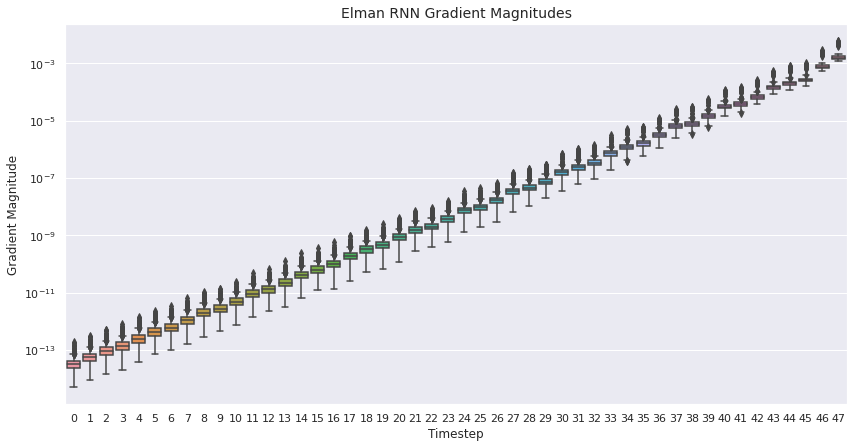

In [26]:
# Prepare collected gradients for plotting.
gradients_prepared = pd.melt(gradient_data, value_vars=gradient_data.columns)
gradients_prepared.columns = ('Timestep', 'Gradient Magnitude')

# Define plotting figure and corresponding attributes.
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Elman RNN Gradient Magnitudes', fontsize=14)
ax.set(yscale='log')

# Plot pre-processed gradients.
_ = sns.boxplot(x='Timestep', y='Gradient Magnitude', data=gradients_prepared, ax=ax)

<p>This figure prominently shows an <i>exponential</i> decrease of the gradient magnitude over time. The magnitude of the gradients of the loss with respect to the sequence elements becomes much smaller for elements in earlier positions than for elements in later positions. Even if we would train the model for more epochs, the vanishing gradient problem itself wouldn't vanish.</p>

<a name="latch-gradients-lstm"></a><h3 style="color:rgb(0,120,170)">Long Short-Term Memory (LSTM)</h3>
<p>Now let's take a look at LSTMs. For this purpose it's enough to realize that there is a path through the LSTM that does not pass through any activation function (see the equations above, especially keep an eye on the <i>constant error carousel</i>). Therefore, one can go into the past without multiplying possible problematic function derivatives. Consequently, one does not expect exponentially decreasing gradients in LSTMs.</p>

In [27]:
# Set random seed for reproducibility.
u4.set_seed(42)

# Create LSTM instance for gradient recording.
target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = LSTM(input_size=data_latch.num_characters, output_size=data_latch.num_targets).to(target_device)

In [28]:
gradient_data = collect_gradients(model=lstm_model, loader=data_loader_train)

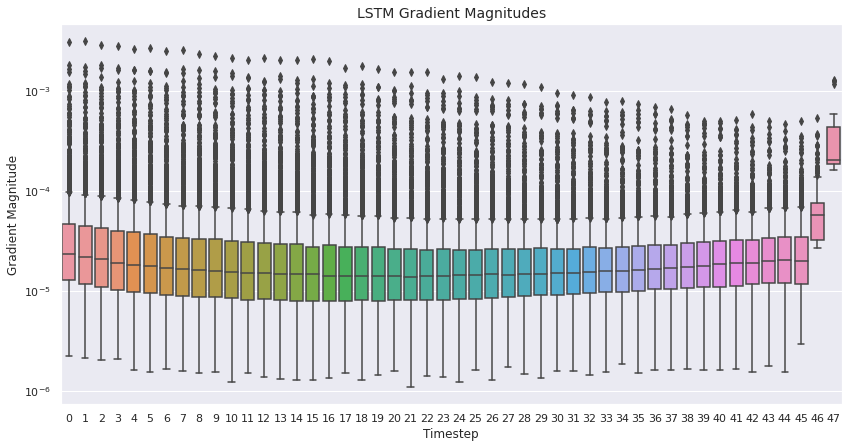

In [29]:
# Prepare collected gradients for plotting.
gradients_prepared = pd.melt(gradient_data, value_vars=gradient_data.columns)
gradients_prepared.columns = ('Timestep', 'Gradient Magnitude')

# Define plotting figure and corresponding attributes.
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('LSTM Gradient Magnitudes', fontsize=14)
ax.set(yscale='log')

# Plot pre-processed gradients.
_ = sns.boxplot(x='Timestep', y='Gradient Magnitude', data=gradients_prepared, ax=ax)

<p>Exactly as expected, <i>no</i> exponentially decreasing gradient magnitude in LSTMs (w.r.t. the implementation as applied in these examples).</p>

<a name="latch-gradients-elman-vs-lstm"></a><h3 style="color:rgb(0,120,170)">Elman RNN vs. LSTM</h3>
<p>The difference in gradient magnitudes is even more visible if we plot the Elman RNN gradients together with the ones collected from our LSTM implementation. Especially, keep an eye on the <i>y</i>-axis and the correspionding value range.</p>

In [30]:
models = []
for network_class in (ElmanRNN, LSTM):
    # Set random seed for reproducibility.
    u4.set_seed(42)
    
    # Create new network model instances.
    models.append(network_class(input_size=data_latch.num_characters, output_size=data_latch.num_targets))
    models[-1] = models[-1].to(target_device)

In [31]:
gradients = [collect_gradients(model=model, loader=data_loader_train) for model in models]

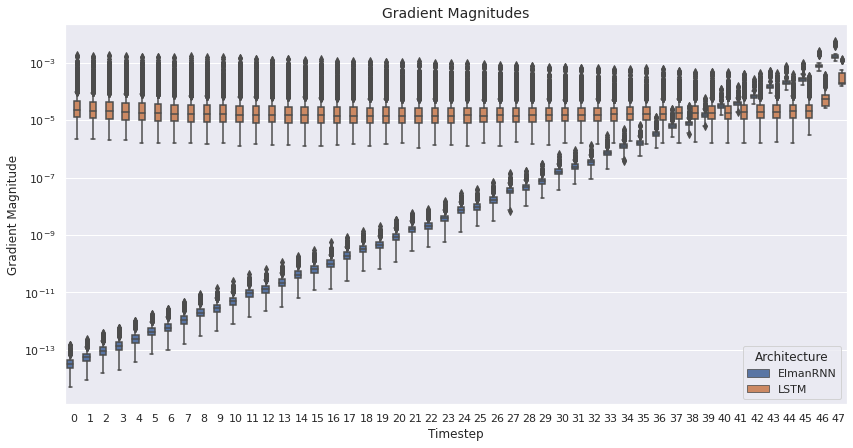

In [32]:
# Prepare collected gradients for plotting.
gradients_prepared = []
for model, gradient in zip(models, gradients):
    gradients_prepared.append(pd.melt(gradient, value_vars=gradient.columns))
    gradients_prepared[-1].columns = ('Timestep', 'Gradient Magnitude')
    gradients_prepared[-1]['Architecture'] = type(model).__name__

# Combine all gradients in a single data frame.
gradients_prepared = pd.concat(gradients_prepared)

# Define plotting figure and corresponding attributes.
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Gradient Magnitudes', fontsize=14)
ax.set(yscale='log')

# Plot pre-processed gradients.
_ = sns.boxplot(x='Timestep', y='Gradient Magnitude', hue='Architecture', data=gradients_prepared, ax=ax)

<a name="tasks-four"></a><h3 style="color:rgb(0,120,170)">Tasks</h3>
    <div class="alert alert-warning">
        Execute the notebook until here and try to solve the following tasks:
        <ul>
            <li>Generate latch sequence data sets with different values for the various defining properties as described in the table above.</li>
            <li>For each newly generated latch sequence data set, train <tt>DenseFNN</tt>, <tt>ElmanRNN</tt> and <tt>LSTM</tt> models.</li>
            <li>Visualize and compare the gradients of the respective settings. What do you observe?</li>
        </ul>
</div>